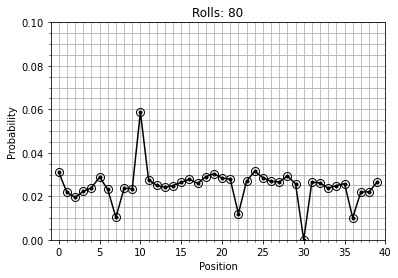

Sum of probabilities: 1.0


In [1]:
#!/usr/bin/env python3

# Author: Dario Trinchero

import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML

# NOTE Written for Python3, Numpy 1.16.3, & Matplotlib 3.0.3

final_roll = 80

def jump_to(A, f, t, p):
    ''' Add a transition to transition matrix A from state(s) f to state t with probability p.
    All transitions to any state should be added before adding a transition from that state. '''
    try:
        for state in f: A[t, :] += p * A[state, :]
    except TypeError: A[t, :] += p * A[f, :]

def add_jumps(A):
    ''' Add transitions to matrix A for each jump from one tile to another according to the rules
    of US Standard 2008 Edition of Monopoly, assuming A already has dice roll transitions. '''
    # "Go to Jail" tile
    jump_to(A, 30, 10, 1)
    A[30, :] *= 0

    # Chance cards
    jump_to(A, [7, 22, 36], 10, 1.0 / 16) # -> Jail
    jump_to(A, [7, 22, 36], 0, 1.0 / 16)  # -> Start
    jump_to(A, [7, 22, 36], 24, 1.0 / 16) # -> Illinois Ave
    jump_to(A, [7, 22, 36], 11, 1.0 / 16) # -> St. Charles Place
    jump_to(A, 7, 12, 1.0 / 16)           # -> Nearest utility
    jump_to(A, [22, 36], 28, 1.0 / 16)    # -> Nearest utility
    jump_to(A, 7, 5, 1.0 / 16)            # -> Nearest railroad
    jump_to(A, 22, 25, 1.0 / 16)          # -> Nearest railroad
    jump_to(A, 36, 35, 1.0 / 16)          # -> Nearest railroad
    jump_to(A, [7, 22, 36], 5, 1.0 / 16)  # -> Reading Railroad
    jump_to(A, [7, 22, 36], 39, 1.0 / 16) # -> Boardwalk
    jump_to(A, 7, 4, 1.0 / 16)            # <- Back 3 spaces
    jump_to(A, 22, 19, 1.0 / 16)          # <- Back 3 spaces
    jump_to(A, 36, 33, 1.0 / 16)          # <- Back 3 spaces (-> Community Chest)

    # Ending on Chance tiles
    A[7, :] *= 7.0 / 16
    A[22, :] *= 7.0 / 16
    A[36, :] *= 7.0 / 16

    # Community Chests
    jump_to(A, [2, 17, 33], 10, 1.0 / 17) # -> Jail
    jump_to(A, [2, 17, 33], 0, 1.0 / 17)  # -> Start

    # Ending on Community Chest tiles
    A[2, :] *= 15.0 / 17
    A[17, :] *= 15.0 / 17
    A[33, :] *= 15.0 / 17

def transition_matrix():
    ''' Create transition matrix representing all movements from one tile to another in US
    Standard 2008 Edition of Monopoly. '''
    A = np.block([[np.zeros((1, 28)), np.array([[1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 0]])],
        [np.zeros((39, 40))]]) / 36
    for j in range(39): A[j + 1, :] = np.concatenate(([A[j, -1]], A[j, :-1]))
    add_jumps(A)
    return A

def animate(A, p0, rolls, delay=50, limit=True):
    ''' Animate evolution of the probability distribution p0 for given number of rolls (transitions)
    and transition matrix A. If limit is True, also show limiting probability distribution (obtained
    as normalized eigenvector of A for eigenvalue 1) after animation completes. '''
    fig = plt.figure()
    line, = plt.plot(np.arange(40), p0, 'k.-')

    plt.title('Rolls: 0')
    plt.xlabel('Position')
    plt.ylabel('Probability')
    plt.xlim(-1, 40)
    plt.ylim(0, 0.1)
    plt.minorticks_on()
    plt.grid(True, which='both')

    def update(frame):
        nonlocal A, p0, line, limit
        line.set_data(np.arange(40), p0)
        plt.title('Rolls: ' + str(frame))
        if frame > 0: p0[:] = A.dot(p0) # p0[:] ensures external array is changed

        if frame == rolls and limit:
            v = np.real(la.eig(A)[1][:, 0])
            plt.plot(v / np.sum(v), 'ko', fillstyle='none', markersize=8)

    ani = anim.FuncAnimation(fig, update, rolls + 1, interval=delay, blit=False, repeat=False)
    HTML(ani.to_html5_video())
    plt.show()

if __name__ == '__main__':
    # Initialize p0 and A
    p0 = np.block([[np.array([[1]])], [np.zeros((39, 1))]])
    A = transition_matrix()

    # Run animation
    animate(A, p0, final_roll, delay=50, limit=True)

    # Check probability sum
    print('Sum of probabilities: ' + str(np.around(np.sum(p0), decimals=8)))
 